In [1]:
import random
from dro import OnlineDRO
import numpy as np
import matplotlib.pyplot as plt
import collections as col


In [25]:
class DiscountedAverage:
    def __init__(self, tau):
        self.tau = tau
        self.sumr = 0
        self.n = 0
    
    def update(self, r):
        self.sumr = self.tau * self.sumr + r
        self.n = self.tau * self.n + 1
    
    def current(self):
        try:
            return self.sumr / self.n
        except:
            print(f'fuu r: {self.sumr} tau: {self.tau} n: {self.n}')
            raise Exception('you done')

class MovingAverage:
    def __init__(self, size):
        self.samples = col.deque()
        self.size = size
    
    def update(self, r):
        self.samples.append(r)
        if len(self.samples) > self.size:
            self.samples.popleft()
    
    def current(self):
        return sum(self.samples) / len(self.samples)

def gen_pmf(actions, epsilon, exploit_idx):
    pmf = [epsilon / actions] * actions
    pmf[exploit_idx] += 1 - epsilon
    return pmf


def sample_custom_pmf(pmf, rng):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = rng.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index
    raise Exception("can't sample")


def run(policy, eval, r, c):
    np.random.seed(seed=10)
    ci = OnlineDRO.OnlineCressieReadLB(alpha=0.05, tau=0.999)
    avg = DiscountedAverage(tau=0.999)
    for i in range(c):
       p_action = sample_custom_pmf(policy)
       e_action = sample_custom_pmf(eval)
       
       w = 1 / policy[p_action]
       if p_action != e_action:
           w = 0
       ci.update(c=1, w=w, r=r[p_action])
       avg.update(r[p_action])
       ci.recomputeduals()
       lb = ci.duals[0][0]
       m = avg.current()
       step = count / 10
       if (i % step) == (step - 1):
        #    print(f's: {i} policy: {p_action} eval: {e_action} r: {r[p_action]} w:{w} ')
           print(f'[{i}] lb: {lb} mean: {m}')
    
    return (ci.duals[0][0], avg.current())

In [34]:

def run_2(policy, eval, get_reward, count, tau=0.999, use_old):
    rng = None
    if use_old:
        rng = np.random.RandomState(101)
    else:
        rng = np.random.default_rng(101)
    m_size = int(1 / (1 - tau)) + 1

    ci = OnlineDRO.OnlineCressieReadLB(alpha=0.05, tau=tau)
    avg = DiscountedAverage(tau=tau)
    avg2 = MovingAverage(size=m_size)
    w_avg = DiscountedAverage(tau=tau)
    w_avg2 = MovingAverage(size=m_size)

    avg_lst = []
    avg2_lst = []
    w_avg_lst = []
    w_avg2_lst = []
    lb_lst = []
    for i in range(count):
       p_action = sample_custom_pmf(policy,rng)
       e_action = sample_custom_pmf(eval, rng)
       reward = get_reward(i, p_action)

       w = 1 / policy[p_action]
       if p_action != e_action:
           w = 0
       ci.update(c=1, w=w, r=reward)
       avg.update(reward)
       avg2.update(reward)
       w_avg.update(w)
       w_avg2.update(w)
       ci.recomputeduals()

       avg_lst.append(avg.current())
       avg2_lst.append(avg2.current())
       w_avg_lst.append(w_avg.current())
       w_avg2_lst.append(w_avg2.current())
       lb_lst.append(ci.duals[0][0])
    return (lb_lst, avg_lst, avg2_lst, w_avg_lst, w_avg2_lst)

def switch_midpoint(idx, action, limit, p0, p1):
    if idx < limit:
        return p0[action]
    return p1[action]



SyntaxError: non-default argument follows default argument (<ipython-input-34-66c773208edf>, line 1)

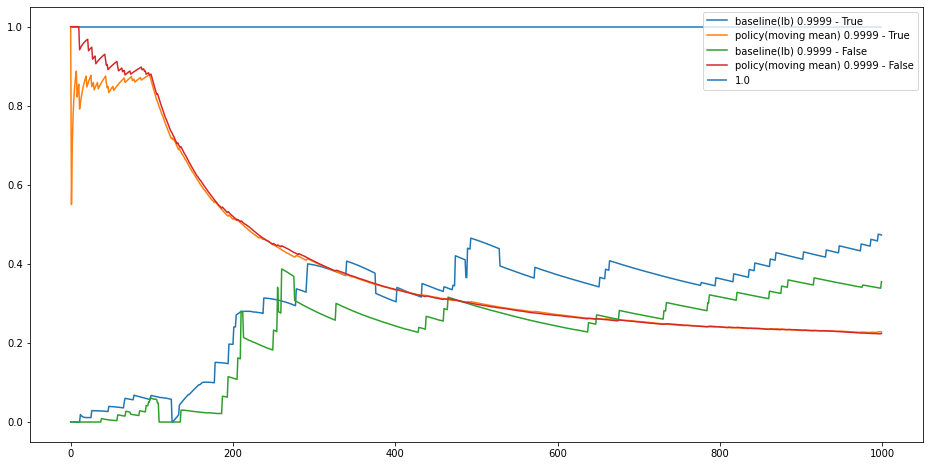

In [38]:

policy = gen_pmf(4, 0.2, 3)
baseline = gen_pmf(4, 0.2, 0)

p0_reward = [0.1, 0.3, 0.3, 1]
p1_reward = [1, 0.3, 0.3, 0.1]

count = 1000
switch_point = 100

def plot_tau(tau, use_old=False):
    gr = lambda i,a : switch_midpoint(i, a, switch_point, p0_reward, p1_reward)
    res = run_2(policy, baseline, gr, count, tau, use_old)
    plt.plot(res[0], label=f'baseline(lb) {tau} - {use_old}')
    # plt.plot(res[1], label=f'policy(discounted mean) {tau}')
    plt.plot(res[2], label=f'policy(moving mean) {tau} - {use_old}')
    # plt.plot(res[3], label=f'discounted-avg weight {tau}')
    # plt.plot(res[4], label=f'moving-avg weight {int( 1/(1-tau))} - {use_old}')


plt.figure(figsize=(16, 8))
# plot_tau(0.95)
# plot_tau(0.995)
# plot_tau(0.999)
plot_tau(0.9999, True)
plot_tau(0.9999, False)
# plot_tau(0.999999)
# plt.vlines(x = switch_point, ymin = 0, ymax = 1, label = 'switch point')
plt.hlines(y = 1, xmin = 0, xmax = count, label = "1.0")
plt.legend()
